## Classification

The classification tools let you reclassify the values in an xarray DataArray into a new set of values based on set bins.

### Importing Packages

In [1]:
import numpy as np
import xarray as xr

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

### Generate Terrain Data

To test out the classification functions, we'll need some rasterized data. We can generate an artificial digital elevation model (*dem*), or terrain, with xarray-spatial's `generate_terrain`, with the help of datashader's Canvas for the aggregation of values into a raster.

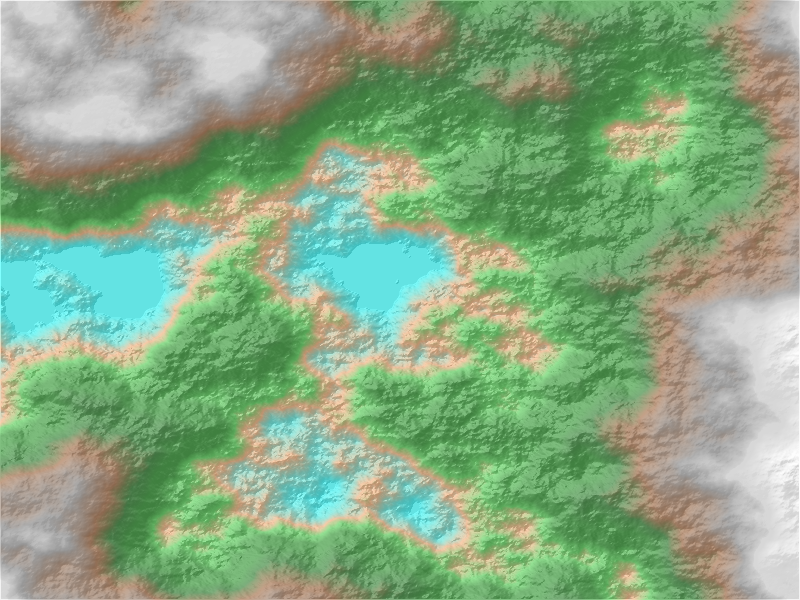

In [2]:
from xrspatial import generate_terrain
from xrspatial import hillshade

W = 800
H = 600

template_terrain = xr.DataArray(np.zeros((H, W)))
x_range = (-20e6, 20e6)
y_range = (-20e6, 20e6)

terrain = generate_terrain(
    template_terrain, x_range=x_range, y_range=y_range, seed=1, zfactor=1000
)
stack(
    shade(hillshade(terrain), cmap=["grey", "white"]),
    shade(terrain, cmap=Elevation, alpha=128),
)

### Reclassify

#### Quantile Reclassify

One method of reclassification is by *quantile*. In this method, the set of all values is divided into bins such that each bin contains the same number of cell values. This method works better for non-evenly distributed value sets.

Let's try it out.

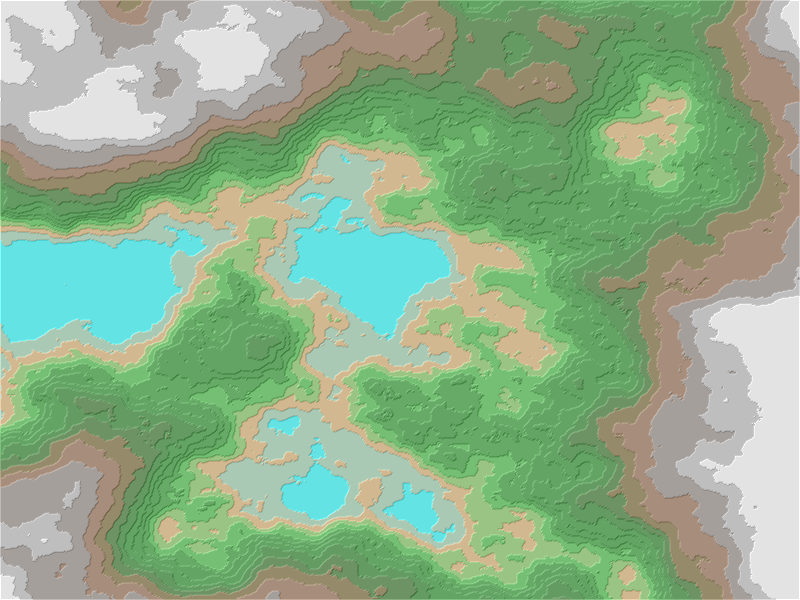

In [3]:
from xrspatial import hillshade
from xrspatial import quantile

qcut_agg = quantile(terrain, k=15)

stack(
    shade(hillshade(qcut_agg), cmap=["gray", "white"], alpha=255, how="linear"),
    shade(qcut_agg, cmap=Elevation, alpha=128, how="linear"),
)

#### Equal Interval Reclassify

Another method of reclassification is equal interval. This simply divides the entire values range by the given number of bins and assigns the vlaues into those bins based on where the value lies.

As you can see below, for our terrain, this flattens out a lot of our values since our data is not evenly distributed.

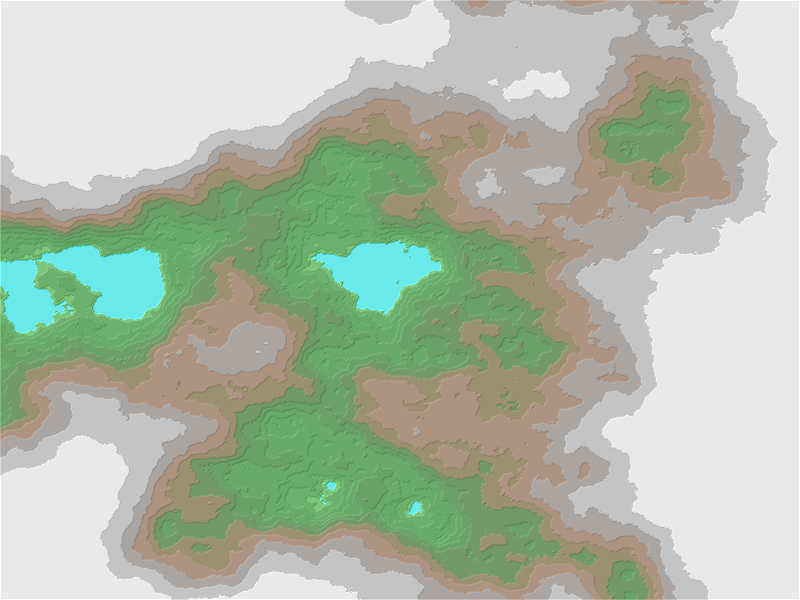

In [4]:
from xrspatial.classify import equal_interval
from xrspatial import hillshade

equal_interval_agg = equal_interval(terrain, k=15)

stack(
    shade(
        hillshade(equal_interval_agg), cmap=["gray", "white"], alpha=255, how="linear"
    ),
    shade(equal_interval_agg, cmap=Elevation, alpha=128, how="linear"),
)

#### Natural Breaks (Jenks) Reclassify

This is another non-linear classification method that is best for non-evenly distributed data that does not skew only towards the high or low range.

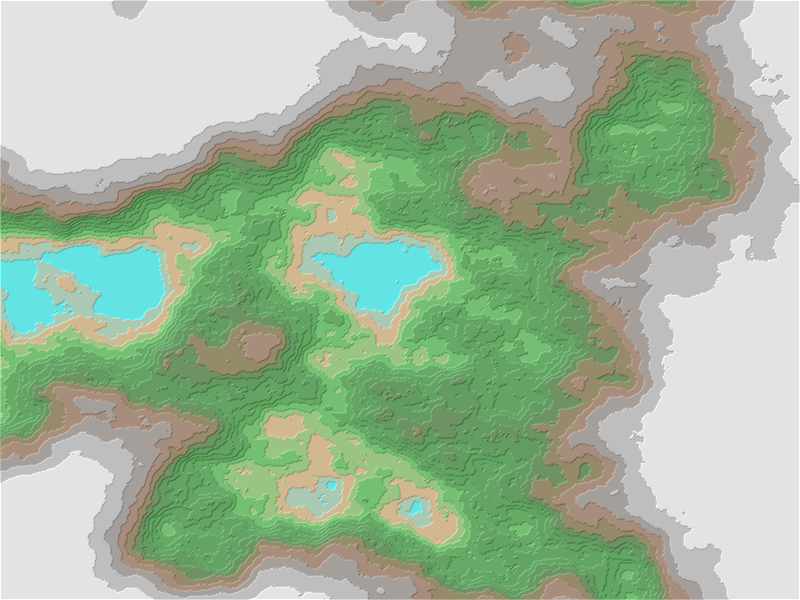

In [5]:
from xrspatial.classify import natural_breaks
from xrspatial import hillshade

natural_breaks_agg = natural_breaks(terrain, num_sample=1000, k=15)

stack(
    shade(
        hillshade(natural_breaks_agg), cmap=["gray", "white"], alpha=255, how="linear"
    ),
    shade(natural_breaks_agg, cmap=Elevation, alpha=128, how="linear"),
)

#### Regions: Groupby Pixel-Value Connectivity

Xarray-spatial's `regions` function creates a raster with unique regions based on connected pixel areas with the same value. Regions assigns each such area a unique integer value.

For our reclassified rasters, this can easily be applied to separate out all of the equal-elevation 'plateaus' and name each one.

Connectivity can be set to either 4 or 8-pixel neighborhoods, with the default being 4.

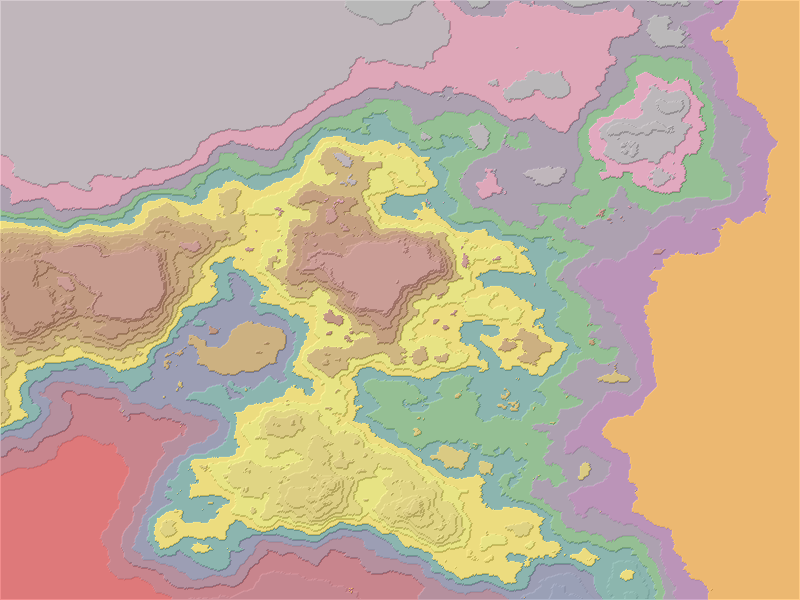

In [6]:
from xrspatial.zonal import regions
from xrspatial import hillshade
from datashader.colors import Set1, Set3

regions_agg = regions(equal_interval_agg, neighborhood=4)

stack(
    shade(hillshade(regions_agg), cmap=["gray", "white"], alpha=255, how="linear"),
    shade(regions_agg, cmap=Set1, alpha=128, how="eq_hist"),
)

### References

- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA